### Introduction

We are working with the *ManyBabies 1 - Infant-directed Speech Preference* dataset that has been published at:
https://github.com/manybabies/mb1-analysis-public

#### Setup

Attach packages to be used

In [34]:
using CSV            # read and write .csv files
using Gadfly         # plotting
using DataFrames     
using DataFramesMeta # dplyr-like operations
using MixedModels
using StatsBase      # basic statistics functions
using RCall          # Call R from Julia
R"library(lme4)"
R"library(dplyr)"

RObject{StrSxp}
 [1] "bindrcpp"  "dplyr"     "lme4"      "Matrix"    "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     


#### Data preprocessing

Download and read the data, using CSV. 
Inspect the contents. 

In [2]:
mb1 = CSV.read(
    download("https://raw.githubusercontent.com/manybabies/mb1-analysis-public/fa7e77c026a4dc0b0bb7e78d3bf3771c9bc2f7cb/processed_data/03_data_trial_main.csv"),
    missingstrings=["NA","N/A"],
    truestrings=["TRUE"],
    falsestrings=["FALSE"])
describe(mb1)

16×8 DataFrame. Omitted printing of 4 columns
│ Row │ variable       │ mean      │ min                 │ median │
│     │ Symbol         │ Union…    │ Any                 │ Union… │
├─────┼────────────────┼───────────┼─────────────────────┼────────┤
│ 1   │ lab            │           │ babylabbrookes      │        │
│ 2   │ subid          │           │ 1                   │        │
│ 3   │ subid_unique   │           │ babylabbrookes:mb01 │        │
│ 4   │ trial_order    │ 2.47842   │ 1                   │ 2.0    │
│ 5   │ trial_num      │ 8.5       │ 1                   │ 8.5    │
│ 6   │ trial_type     │           │ ADS                 │        │
│ 7   │ stimulus_num   │ 4.37316   │ 1                   │ 4.0    │
│ 8   │ method         │           │ eyetracking         │        │
│ 9   │ age_days       │ 291.995   │ 92                  │ 286.0  │
│ 10  │ age_mo         │ 9.59326   │ 3.02259             │ 9.3963 │
│ 11  │ age_group      │           │ 12-15 mo            │        │
│ 12  │ nae            │ 0.457707  │ 0                   │ 0.0    │
│ 13  │ gender         │           │ 0                   │        │
│ 14  │ second_session │ 0.0184909 │ 0                   │ 0.0    │
│ 15  │ looking_time   │ 7.80084   │ 2.0                 │ 6.23   │
│ 16  │ missing        │ 0.278258  │ 0                   │ 0.0    │

The `gender` variable should be `F`, `M`, or `missing` but some values are miscoded. 

In [3]:
countmap(mb1.gender)

Dict{Union{Missing, String},Int64} with 6 entries:
  missing  => 4383
  "M"      => 16708
  "0"      => 16
  "FEMALE" => 229
  "F"      => 15666
  "MALE"   => 262

So first let's get the data in shape. In Julia, there is DataFramesMeta for this purpose. 

Recode the levels of `gender`, add the `item` variable, center the `age_mo`, and relevel the `method` and `age_group` to match with the R data frame.
Add log-transformed looking time `log_lt` for visualization. 
Drop observations with a missing response (`looking_time`).

In [4]:
mb1a = @linq mb1 |>
    transform(gender = recode(:gender, "0"=>missing, "MALE"=>"M", "FEMALE"=>"F"),
              item = string.(:stimulus_num, :trial_type),
              age_mo = :age_mo .- mean(:age_mo),
              log_lt = log.(:looking_time),
              method = levels!(categorical(:method), ["singlescreen", "eyetracking", "hpp"]),
              age_group = levels!(categorical(:age_group), ["3-6 mo", "6-9 mo", "9-12 mo", "12-15 mo"])) |>
    where(.!ismissing.(:looking_time));
disallowmissing!(mb1a, error=false);
describe(mb1a)

18×8 DataFrame. Omitted printing of 4 columns
│ Row │ variable       │ mean      │ min                 │ median   │
│     │ Symbol         │ Union…    │ Any                 │ Union…   │
├─────┼────────────────┼───────────┼─────────────────────┼──────────┤
│ 1   │ lab            │           │ babylabbrookes      │          │
│ 2   │ subid          │           │ 1                   │          │
│ 3   │ subid_unique   │           │ babylabbrookes:mb01 │          │
│ 4   │ trial_order    │ 2.48113   │ 1                   │ 2.0      │
│ 5   │ trial_num      │ 7.8174    │ 1                   │ 7.0      │
│ 6   │ trial_type     │           │ ADS                 │          │
│ 7   │ stimulus_num   │ 4.27615   │ 1                   │ 4.0      │
│ 8   │ method         │           │ singlescreen        │          │
│ 9   │ age_days       │ 286.981   │ 92                  │ 278.0    │
│ 10  │ age_mo         │ -0.164721 │ -6.57067            │ -0.45979 │
│ 11  │ age_group      │           │ 3-6 mo              │          │
│ 12  │ nae            │ 0.459714  │ 0                   │ 0.0      │
│ 13  │ gender         │           │ F                   │          │
│ 14  │ second_session │ 0.012493  │ 0                   │ 0.0      │
│ 15  │ looking_time   │ 7.80084   │ 2.0                 │ 6.23     │
│ 16  │ missing        │ 0.0       │ 0                   │ 0.0      │
│ 17  │ item           │           │ 1ADS                │          │
│ 18  │ log_lt         │ 1.86434   │ 0.693147            │ 1.82938  │

A histogrm of the `looking_time` shows the thresholding effect.
Trials with looking times shorter than 2s were excluded as uninformative, and maximal trial duration was 18s. 

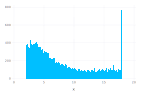

In [5]:
plot(x=mb1a.looking_time, Geom.histogram)

We can also split the plot by our key comparison to inspect how the censoring affects the DV in the two conditions.

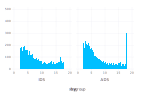

In [6]:
plot(x=mb1a.looking_time, xgroup=mb1a.trial_type, Geom.subplot_grid(Geom.histogram))

The data are being log transformed in the analysis, so we can also visualize that.

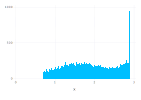

In [7]:
plot(x=mb1a.log_lt, Geom.histogram)


### Model Fitting 

Fit the linear mixed-effects model from the paper.

In [8]:
m1form = @formula log(looking_time) ~ trial_type * method +
                   trial_type * trial_num +
                   age_mo * trial_num +
                   trial_type * age_mo * nae +
                   (1 | subid_unique) +
                   (1 | lab) + 
                   (1 | item);
m1 = fit(MixedModel, m1form, mb1a, REML=true)

Linear mixed model fit by REML
 :(log(looking_time)) ~ 1 + trial_type + method + trial_num + age_mo + nae + trial_type & method + trial_type & trial_num + age_mo & trial_num + trial_type & age_mo + trial_type & nae + age_mo & nae + trial_type & age_mo & nae + (1 | subid_unique) + (1 | lab) + (1 | item)
 REML criterion at convergence: 43346.73059085243

Variance components:
                Column     Variance     Std.Dev.  
subid_unique (Intercept)  0.0729112185 0.270020774
lab          (Intercept)  0.0347560111 0.186429641
item         (Intercept)  0.0033137747 0.057565395
Residual                  0.2572456390 0.507193887
 Number of obs: 26895; levels of grouping factors: 2302, 67, 16

  Fixed-effects parameters:
────────────────────────────────────────────────────────────────────────────────────
                                           Estimate   Std.Error     z value  P(>|z|)
────────────────────────────────────────────────────────────────────────────────────
(Intercept)          

The thresholding of the response produces some unusual patterns in the residuals versus fitted values.

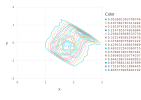

In [9]:
plot(x=fitted(m1), y=residuals(m1), Geom.density2d)

#### Intended maximal model 

Fit the authors' intended maximal mixed-effects model. lme4 in R did initally not converge and now throws singularity warnings for this model. 
We switch from REML to ML. 

In [10]:
m2form = @formula log(looking_time) ~ trial_type * method +
                   trial_type * trial_num +
                   age_mo * trial_num +
                   trial_type * age_mo * nae +
                   (1 + trial_type * trial_num | subid_unique) +
                   (1 + trial_type * age_mo | lab) +
                   (1 + method + age_mo * nae | item);
m2 = fit(MixedModel, m2form, mb1a, REML=false)

Linear mixed model fit by maximum likelihood
 :(log(looking_time)) ~ 1 + trial_type + method + trial_num + age_mo + nae + trial_type & method + trial_type & trial_num + age_mo & trial_num + trial_type & age_mo + trial_type & nae + age_mo & nae + trial_type & age_mo & nae + (1 + trial_type + trial_num + trial_type & trial_num | subid_unique) + (1 + trial_type + age_mo + trial_type & age_mo | lab) + (1 + method + age_mo + nae + age_mo & nae | item)
     logLik        -2 logLik          AIC             BIC       
 -2.14046565×10⁴  4.28093131×10⁴  4.29233131×10⁴  4.33906957×10⁴

Variance components:
                        Column              Variance      Std.Dev.     Corr.
subid_unique (Intercept)                  0.108657666418 0.3296326234
             trial_type: IDS              0.001031161464 0.0321117029  0.68
             trial_num                    0.000642386005 0.0253453350 -0.66 -0.11
             trial_type: IDS & trial_num  0.000104618508 0.0102283189  0.03 -0.62 -0.14
lab 

#### Model check and optimization

`rePCA` is analogous to rePCA() in R's lme4, which runs a Principal Component Analysis on the random effects matrix estimates to be able to detect overfitting. In MixedModels, it is a property of the fitted model. 

In [11]:
m2.rePCA

(subid_unique = [0.9906975139117434, 0.9980022797019362, 1.0, 1.0], lab = [0.956865817471483, 0.9974956661603498, 0.9999955524016876, 1.0], item = [0.7797043284626453, 0.9910492736915271, 0.9999980977737649, 0.9999997526592282, 1.0, 1.0])

According to `rePCA` there is overparameterization for each of the three random factors. 
Let's go with zerocorr parameter linear mixed models. 

In [12]:
m3form = @formula log(looking_time) ~ trial_type * method +
                   trial_type * trial_num +
                   age_mo * trial_num +
                   trial_type * age_mo * nae +
                   zerocorr(1 + trial_type * trial_num | subid_unique) +
                   zerocorr(1 + trial_type * age_mo | lab) +
                   zerocorr(1 + method + age_mo * nae | item);
m3 = fit(MixedModel, m3form, mb1a, REML=false)


(subid_unique = [0.9759965347542288, 0.9961939005771142, 0.999184961312711, 1.0], lab = [0.9594243003771457, 0.9976482005605243, 1.0, 1.0], item = [0.6580132360928914, 0.8825022483819757, 0.9402624329261646, 0.9937156136208628, 0.9975870406968166, 1.0])

In [ ]:

m3.rePCA

Looks like quite a few variance components have very small values. Drop interaction terms and check LRT.

In [13]:
m4form = @formula log(looking_time) ~ trial_type * method +
                   trial_type * trial_num +
                   age_mo * trial_num +
                   trial_type * age_mo * nae +
                   zerocorr(1 + trial_type | subid_unique) +
                   zerocorr(1 + age_mo | lab) +
                   zerocorr(1 + method + nae | item);
m4 = fit(MixedModel, m4form, mb1a, REML=false)



(subid_unique = [0.9475870473969846, 1.0], lab = [0.9599811978416725, 1.0], item = [0.6248996404188225, 0.8408354299133266, 0.9383990272079008, 1.0])

In [ ]:
m4.rePCA


This looks ok. So let's expand with CPs again. 
Intermediate linear mixed models showed that CP is not supported for `Subject`.

In [31]:
m5form = @formula log(looking_time) ~ trial_type * method +
                   trial_type * trial_num +
                   age_mo * trial_num +
                   trial_type * age_mo * nae +
                   zerocorr(1 + trial_type | subid_unique) +
                   (1 + method + nae | item) +
                   (1 + age_mo | lab);
m5 = fit(MixedModel, m5form, mb1a, REML=false)


Linear mixed model fit by maximum likelihood
 :(log(looking_time)) ~ 1 + trial_type + method + trial_num + age_mo + nae + trial_type & method + trial_type & trial_num + age_mo & trial_num + trial_type & age_mo + trial_type & nae + age_mo & nae + trial_type & age_mo & nae + MixedModels.ZeroCorr((1 + trial_type | subid_unique)) + (1 + method + nae | item) + (1 + age_mo | lab)
     logLik        -2 logLik          AIC             BIC       
 -2.15731287×10⁴  4.31462574×10⁴  4.32082574×10⁴  4.34624479×10⁴

Variance components:
                    Column          Variance     Std.Dev.    Corr.
subid_unique (Intercept)          0.06714497154 0.259123468
             trial_type: IDS      0.00368944829 0.060740829   .  
lab          (Intercept)          0.02665302196 0.163257533
             age_mo               0.00108790727 0.032983439 -0.22
item         (Intercept)          0.00178404585 0.042237967
             method: eyetracking  0.00040883138 0.020219579 -0.30
             method: hpp  

In [32]:

m5.rePCA

(subid_unique = [0.9479144701830107, 1.0], lab = [0.9627415077368152, 1.0], item = [0.7203386399617959, 0.9216533715403697, 1.0, 1.0])


That looks good and there are sizeable item-related correlation parameters. 




### What happens if the random effects are not proberly nested?

We have labs and participants within labs, so if we naively use those variables, what would happen?

Note that we are not fitting the model (it takes a very long time, an indicator something is going on), we instead construct and evaluate it. 

In [36]:
m2form_nesting = @formula log(looking_time) ~ trial_type * method +
                   trial_type * trial_num +
                   age_mo * trial_num +
                   trial_type * age_mo * nae +
                   (1 + trial_type * trial_num | subid) +
                   (1 + trial_type * age_mo | lab) +
                   (1 + method + age_mo * nae | item);

m2n = LinearMixedModel(m2form_nesting, mb1a) # Construct the model 
#fit!(m2n) # Fit the model we constructed 
describeblocks(m2n)

1,1: UniformBlockDiagonal{Float64} (7744, 7744) UniformBlockDiagonal{Float64}
2,1: SparseArrays.SparseMatrixCSC{Float64,Int32} (268, 7744) BlockedSparse{Float64,4,4}
2,2: UniformBlockDiagonal{Float64} (268, 268) Array{Float64,2}
3,1: Array{Float64,2} (96, 7744) Array{Float64,2}
3,2: Array{Float64,2} (96, 268) Array{Float64,2}
3,3: UniformBlockDiagonal{Float64} (96, 96) Array{Float64,2}
4,1: Array{Float64,2} (15, 7744) Array{Float64,2}
4,2: Array{Float64,2} (15, 268) Array{Float64,2}
4,3: Array{Float64,2} (15, 96) Array{Float64,2}
4,4: Array{Float64,2} (15, 15) Array{Float64,2}
5,1: Array{Float64,2} (1, 7744) Array{Float64,2}
5,2: Array{Float64,2} (1, 268) Array{Float64,2}
5,3: Array{Float64,2} (1, 96) Array{Float64,2}
5,4: Array{Float64,2} (1, 15) Array{Float64,2}
5,5: Array{Float64,2} (1, 1) Array{Float64,2}


Let's compare that to the blocks in the original model.

In [37]:
describeblocks(m2)

1,1: UniformBlockDiagonal{Float64} (9208, 9208) UniformBlockDiagonal{Float64}
2,1: SparseArrays.SparseMatrixCSC{Float64,Int32} (268, 9208) BlockedSparse{Float64,4,4}
2,2: UniformBlockDiagonal{Float64} (268, 268) UniformBlockDiagonal{Float64}
3,1: Array{Float64,2} (96, 9208) Array{Float64,2}
3,2: Array{Float64,2} (96, 268) Array{Float64,2}
3,3: UniformBlockDiagonal{Float64} (96, 96) Array{Float64,2}
4,1: Array{Float64,2} (15, 9208) Array{Float64,2}
4,2: Array{Float64,2} (15, 268) Array{Float64,2}
4,3: Array{Float64,2} (15, 96) Array{Float64,2}
4,4: Array{Float64,2} (15, 15) Array{Float64,2}
5,1: Array{Float64,2} (1, 9208) Array{Float64,2}
5,2: Array{Float64,2} (1, 268) Array{Float64,2}
5,3: Array{Float64,2} (1, 96) Array{Float64,2}
5,4: Array{Float64,2} (1, 15) Array{Float64,2}
5,5: Array{Float64,2} (1, 1) Array{Float64,2}


It turns out there are way less unique observations now, which is of course a problem. 


### Dealing with censored data

As we saw in the initial histograms, there are a number of observations that fall on the maximum trial length, so for robustness checks we see what happens if we discard those observations (i.e. all observations where looking time is 18s)


In [17]:
#How many observations are affected exactly?
sum(mb1a.looking_time.==18)

#remove 18s observations
mb1b = @linq mb1a |>
    where(:looking_time.<18);
describe(mb1b)

18×8 DataFrame. Omitted printing of 4 columns
│ Row │ variable       │ mean      │ min                 │ median    │
│     │ Symbol         │ Union…    │ Any                 │ Union…    │
├─────┼────────────────┼───────────┼─────────────────────┼───────────┤
│ 1   │ lab            │           │ babylabbrookes      │           │
│ 2   │ subid          │           │ 1                   │           │
│ 3   │ subid_unique   │           │ babylabbrookes:mb01 │           │
│ 4   │ trial_order    │ 2.48357   │ 1                   │ 2.0       │
│ 5   │ trial_num      │ 7.87462   │ 1                   │ 8.0       │
│ 6   │ trial_type     │           │ ADS                 │           │
│ 7   │ stimulus_num   │ 4.29026   │ 1                   │ 4.0       │
│ 8   │ method         │           │ singlescreen        │           │
│ 9   │ age_days       │ 287.593   │ 92                  │ 279.0     │
│ 10  │ age_mo         │ -0.144624 │ -6.57067            │ -0.426935 │
│ 11  │ age_group      │           │ 3-6 mo              │           │
│ 12  │ nae            │ 0.454941  │ 0                   │ 0.0       │
│ 13  │ gender         │           │ F                   │           │
│ 14  │ second_session │ 0.0125801 │ 0                   │ 0.0       │
│ 15  │ looking_time   │ 7.54306   │ 2.0                 │ 6.07319   │
│ 16  │ missing        │ 0.0       │ 0                   │ 0.0       │
│ 17  │ item           │           │ 1ADS                │           │
│ 18  │ log_lt         │ 1.83841   │ 0.693147            │ 1.80388   │

Let's inspect the data again.

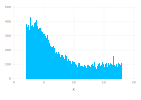

In [18]:
plot(x=mb1b.looking_time, Geom.histogram)

Now we fit the original and final models again, do our conclusions change or are they robust to excluding those observations?

In [19]:
m1b = fit(MixedModel, m1form, mb1b, REML=true)

m5b = fit(MixedModel, m5form, mb1b, REML=false)

Linear mixed model fit by maximum likelihood
 :(log(looking_time)) ~ 1 + trial_type + method + trial_num + age_mo + nae + trial_type & method + trial_type & trial_num + age_mo & trial_num + trial_type & age_mo + trial_type & nae + age_mo & nae + trial_type & age_mo & nae + MixedModels.ZeroCorr((1 + trial_type | subid_unique)) + (1 + method + nae | item) + (1 + age_mo | lab)
     logLik        -2 logLik          AIC             BIC       
 -2.07490471×10⁴  4.14980942×10⁴  4.15600942×10⁴  4.18135109×10⁴

Variance components:
                    Column          Variance     Std.Dev.    Corr.
subid_unique (Intercept)          0.06396064878 0.252904426
             trial_type: IDS      0.00341695873 0.058454758   .  
lab          (Intercept)          0.02363354088 0.153732042
             age_mo               0.00091005444 0.030167109 -0.14
item         (Intercept)          0.00162822866 0.040351315
             method: eyetracking  0.00028107443 0.016765274 -0.30
             method: hpp  

It turns out our conclusions are rather robust to excluding the ceiling data. 


Next, we can check what happens when we do not exclude too short trials. 
For that, we need an unfiltered dataset and re-clean it "by hand" (this is handled by the exclusions-markdowns in the ManyBabies1 repository). 

In [20]:
mb1_raw = CSV.read(
    download("https://raw.githubusercontent.com/manybabies/mb1-analysis-public/fa7e77c026a4dc0b0bb7e78d3bf3771c9bc2f7cb/processed_data/02_validated_output.csv"),
    missingstrings=["NA","N/A"],
    truestrings=["TRUE"],
    falsestrings=["FALSE"])
describe(mb1_raw)

81×8 DataFrame. Omitted printing of 6 columns
│ Row │ variable                    │ mean     │
│     │ Symbol                      │ Union…   │
├─────┼─────────────────────────────┼──────────┤
│ 1   │ lab                         │          │
│ 2   │ subid                       │          │
│ 3   │ trial_num                   │ 7.35365  │
│ 4   │ trial_type                  │          │
│ 5   │ stimulus_num                │ 3.85648  │
│ 6   │ looking_time                │ 6.72888  │
│ 7   │ trial_error                 │ 0.149401 │
│ 8   │ trial_error_type            │          │
│ 9   │ method                      │          │
│ 10  │ ra                          │          │
⋮
│ 71  │ full_term                   │ 0.976837 │
│ 72  │ days_preterm_fixed          │ -10.8296 │
│ 73  │ session_error_recoded       │ 0.104513 │
│ 74  │ session_error_change_reason │          │
│ 75  │ session_error_type_recoded  │          │
│ 76  │ trial_error_recoded         │ 1.0      │
│ 77  │ trial_error_change_reason   │          │
│ 78  │ nae                         │ 0.452756 │
│ 79  │ gender2                     │          │
│ 80  │ age_mo                      │ 9.88087  │
│ 81  │ age_group                   │          │

This datastructure is much wider and hasn't been cleaned yet. There are the 81 columns. Let's take a look. 

In [21]:
show(names(mb1_raw))

Symbol[:lab, :subid, :trial_num, :trial_type, :stimulus_num, :looking_time, :trial_error, :trial_error_type, :method, :ra, :age_days, :trial_order, :session_error, :session_error_type, :notes, :second_session, :lang_group, :lang1, :lang1_exposure, :lang2, :lang2_exposure, :lang3, :lang3_exposure, :caregiver_seat, :macarthur_ladder, :parenta_gender, :parenta_education, :parentb_gender, :parentb_education, :preterm, :days_preterm, :prev_earinfection, :curr_earinfection, :hearing_vision, :hearing_vision_info, :cognitive_developmental, :cognitive_developmental_info, :sib1_age, :sib1_gender, :sib2_age, :sib2_gender, :sib3_age, :sib3_gender, :sib4_age, :sib4_gender, :tod, :season, :race_ethnicity, :gender, :lang4, :lang4_exposure, :bilingual_nae, :bilingual_parenta_nae, :bilingual_parentb_nae, :bilingual_interview_lang, :beard, :ratype, :childcare, :visits, :household_size, :last_feed_min, :last_sleep_min, :termtime, :popnum, :popkm2, :subid_unique, :pilot, :monolingual, :td, :cog_hearing_re

In this datastructure, what has to be removed have already been flagged, and we follow the exclusion procedure now.

In [22]:
#first remove all missing data so the next step with logical operations is not thrown off

mb1_alltrials = @linq mb1_raw |>
    where( 
        .!ismissing.(:age_mo),
        .!ismissing.(:looking_time), 
        .!ismissing.(:trial_type)
    );

mb1_alltrials = @linq mb1_alltrials |>
    where(
        :pilot .== false, #no pilot data
        :age_mo .>= 3, #no participants outside the pre-specified age range
        :age_mo .<= 15,
        :monolingual .== true, #only monolingual participants
        :full_term .== true, #no preterm 
        :td .== true, #no known developmental delays
        :session_error .== false, #no participants where something went wrong during the session_error
        :trial_error .== false, #no trials where something went wrong
        :trial_num .> 0, #no training trials (out of order here)
        :trial_type .!= "TRAIN"
    );

# only keep rows we plan to use (this also avoids issues with empty fields / missing data down the line)
mb1_alltrials = select!(mb1_alltrials, [:lab, :subid, :subid_unique, :trial_order, :trial_num, :trial_type, :stimulus_num, :method, :age_days, :age_mo, :age_group, :nae, :gender, :second_session, :looking_time]);

# apply the same conversions as before for comparability
mb1_alltrials = @linq mb1_alltrials |>
    transform(gender = recode(:gender, "0"=>missing, "MALE"=>"M", "FEMALE"=>"F"),
              item = string.(:stimulus_num, :trial_type),
              age_mo = :age_mo .- mean(:age_mo),
              log_lt = log.(:looking_time),
              method = levels!(categorical(:method), ["singlescreen", "eyetracking", "hpp"]),
              age_group = levels!(categorical(:age_group), ["3-6 mo", "6-9 mo", "9-12 mo", "12-15 mo"])) |>
    where(.!ismissing.(:looking_time));

One exclusion criterion is whether infants contributed at least one usable trial per condition, for simplicity I am copying over the R code 

But first we need to drop all missing values, because they are handled differently in the languages

In [23]:
dropmissing(mb1_alltrials);

@rput mb1_alltrials

32793×17 DataFrame. Omitted printing of 13 columns
│ Row   │ lab            │ subid  │ subid_unique        │ trial_order │
│       │ String         │ String │ String              │ Int64⍰      │
├───────┼────────────────┼────────┼─────────────────────┼─────────────┤
│ 1     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 2     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 3     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 4     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 5     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 6     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 7     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 8     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 9     │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
│ 10    │ babylabbrookes │ mb14   │ babylabbrookes:mb14 │ 2           │
⋮
│ 32783 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32784 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32785 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32786 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32787 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32788 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32789 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32790 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32791 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32792 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │
│ 32793 │ wsigoettingen  │ m417   │ wsigoettingen:m417  │ 1           │

Now we've passed the data to R and can manipulate it there. 

In [24]:
R"""
usable_pairs <- mb1_alltrials %>%
  group_by(subid_unique, stimulus_num) %>%
  summarise(n_usable = sum(!is.na(looking_time))) %>%
  summarise(usable_pair = any(n_usable == 2, na.rm=TRUE)) %>%
  mutate(usable_pair = ifelse(is.na(usable_pair), FALSE, usable_pair)) %>%
  ungroup()

mb1_alltrials <- mb1_alltrials %>% 
  left_join(usable_pairs, by = "subid_unique") %>%
  filter(usable_pair)
"""

RObject{VecSxp}
                          lab           subid                     subid_unique
1              babylabbrookes            mb14              babylabbrookes:mb14
2              babylabbrookes            mb14              babylabbrookes:mb14
3              babylabbrookes            mb14              babylabbrookes:mb14
4              babylabbrookes            mb14              babylabbrookes:mb14
5              babylabbrookes            mb14              babylabbrookes:mb14
6              babylabbrookes            mb14              babylabbrookes:mb14
7              babylabbrookes            mb14              babylabbrookes:mb14
8              babylabbrookes            mb14              babylabbrookes:mb14
9              babylabbrookes            mb14              babylabbrookes:mb14
10             babylabbrookes            mb14              babylabbrookes:mb14
11             babylabbrookes            mb14              babylabbrookes:mb14
12             babylabbrookes       

Now return the data to julia

In [25]:
@rget mb1_alltrials
describe(mb1_alltrials)

18×8 DataFrame. Omitted printing of 4 columns
│ Row │ variable       │ mean        │ min                 │ median    │
│     │ Symbol         │ Union…      │ Any                 │ Union…    │
├─────┼────────────────┼─────────────┼─────────────────────┼───────────┤
│ 1   │ lab            │             │ babylabbrookes      │           │
│ 2   │ subid          │             │ 1                   │           │
│ 3   │ subid_unique   │             │ babylabbrookes:mb01 │           │
│ 4   │ trial_order    │ 2.47802     │ 1                   │ 2.0       │
│ 5   │ trial_num      │ 8.12118     │ 1                   │ 8.0       │
│ 6   │ trial_type     │             │ ADS                 │           │
│ 7   │ stimulus_num   │ 4.36777     │ 1                   │ 4.0       │
│ 8   │ method         │             │ singlescreen        │           │
│ 9   │ age_days       │ 290.624     │ 92                  │ 282.0     │
│ 10  │ age_mo         │ 0.000480221 │ -6.52515            │ -0.282846 │
│ 11  │ age_group      │             │ 12-15 mo            │           │
│ 12  │ nae            │ 0.453655    │ 0                   │ 0.0       │
│ 13  │ gender         │             │ F                   │           │
│ 14  │ second_session │ 0.0185626   │ 0                   │ 0.0       │
│ 15  │ looking_time   │ 6.60064     │ 0.0                 │ 5.10505   │
│ 16  │ item           │             │ 1ADS                │           │
│ 17  │ log_lt         │ -Inf        │ -Inf                │ 1.63023   │
│ 18  │ usable_pair    │ 1.0         │ 1                   │ 1.0       │

Let's inspect the data

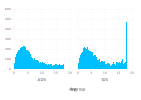

In [26]:
plot(x=mb1_alltrials.looking_time, xgroup=mb1_alltrials.trial_type, Geom.subplot_grid(Geom.histogram))

We need to remove 0 looking time trials, i.e. trials without any data. This is both conceptually appropriate and saves our log transform of the looking times. We also again remove the right-censored data (i.e. looking times of exact 18s)


In [27]:
mb1_alltrials = @linq mb1_alltrials |>
    where(
        :looking_time .> 0, 
        :looking_time .< 18
        );



Let's inspect the data again 

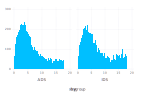

In [28]:
plot(x=mb1_alltrials.looking_time, xgroup=mb1_alltrials.trial_type, Geom.subplot_grid(Geom.histogram))


Now we can finally fit the model again. 

In [29]:
m1_censored = fit(MixedModel, m1form, mb1_alltrials, REML=true)


Linear mixed model fit by REML
 :(log(looking_time)) ~ 1 + trial_type + method + trial_num + age_mo + nae + trial_type & method + trial_type & trial_num + age_mo & trial_num + trial_type & age_mo + trial_type & nae + age_mo & nae + trial_type & age_mo & nae + (1 | subid_unique) + (1 | lab) + (1 | item)
 REML criterion at convergence: 71533.15468423272

Variance components:
                Column     Variance     Std.Dev.  
subid_unique (Intercept)  0.2031352448 0.450705275
lab          (Intercept)  0.1021750032 0.319648249
item         (Intercept)  0.0034664208 0.058876318
Residual                  0.5026865384 0.709003906
 Number of obs: 31167; levels of grouping factors: 2319, 69, 16

  Fixed-effects parameters:
────────────────────────────────────────────────────────────────────────────────────
                                           Estimate   Std.Error     z value  P(>|z|)
────────────────────────────────────────────────────────────────────────────────────
(Intercept)          

Let's look at the residuals again, it's not perfect, yet (of course), but better

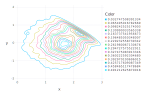

In [30]:
plot(x=fitted(m1_censored), y=residuals(m1_censored), Geom.density2d)
